In [9]:
# Phase 2: Modeling, Stacking & Calibration in Spark + SHAP (Colab-ready)

## Cell 1: Install & Setup in Colab (GPU runtime recommended)
!pip install pyspark shap joblib matplotlib seaborn findspark
import os
import findspark
findspark.init()
# Ensure PySpark uses local[*] master
os.environ['PYSPARK_SUBMIT_ARGS']='--master local[*] pyspark-shell'

In [10]:
## Cell 2: Imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier, LogisticRegression, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import shap
import joblib

In [11]:
## Cell 3: Start Spark Session
spark = SparkSession.builder \
    .appName('Phase2_Colab_Modeling') \
    .config('spark.executor.memory','4g') \
    .config('spark.driver.memory','4g') \
    .getOrCreate()
print('Spark session started')

Spark session started


In [12]:
## Cell 4: Load preprocessed CSVs
train_path = '/content/train_preprocessed.csv'
test_path  = '/content/test_preprocessed.csv'
sdf_train = spark.read.csv(train_path, header=True, inferSchema=True)
sdf_test  = spark.read.csv(test_path, header=True, inferSchema=True)
print('Loaded rows:', sdf_train.count(), sdf_test.count())

Loaded rows: 123492 52926


In [13]:
## Cell 5: Assemble features & cast label
label_col = 'readmit_30_days'
feat_cols = [c for c in sdf_train.columns if c!= label_col]
assembler = VectorAssembler(inputCols=feat_cols, outputCol='features')
sdf_train = assembler.transform(sdf_train).withColumn(label_col, sdf_train[label_col].cast('double'))
sdf_test = assembler.transform(sdf_test).withColumn(label_col, sdf_test[label_col].cast('double'))

In [14]:
## Cell 6: Evaluators
auc_eval = BinaryClassificationEvaluator(labelCol=label_col, metricName='areaUnderROC')
acc_eval = MulticlassClassificationEvaluator(labelCol=label_col, metricName='accuracy')

In [15]:
## Cell 7: Define 3-fold CV & ParamGrids
cv_folds, par = 3, 1

gbt = GBTClassifier(labelCol=label_col, featuresCol='features', seed=42)
gbt_grid = ParamGridBuilder().addGrid(gbt.maxDepth,[5,10]).addGrid(gbt.maxIter,[50,100]).build()
cv_gbt = CrossValidator(estimator=gbt, estimatorParamMaps=gbt_grid, evaluator=auc_eval, numFolds=cv_folds).setParallelism(par)

rf = RandomForestClassifier(labelCol=label_col, featuresCol='features', seed=42)
rf_grid = ParamGridBuilder().addGrid(rf.numTrees,[50,100]).addGrid(rf.maxDepth,[5,10]).build()
cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=rf_grid, evaluator=auc_eval, numFolds=cv_folds).setParallelism(par)

lr = LogisticRegression(labelCol=label_col, featuresCol='features', maxIter=100)
lr_grid = ParamGridBuilder().addGrid(lr.regParam,[0.01,0.1]).addGrid(lr.elasticNetParam,[0.0,0.5,1.0]).build()
cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=lr_grid, evaluator=auc_eval, numFolds=cv_folds).setParallelism(par)

mlp = MultilayerPerceptronClassifier(labelCol=label_col, featuresCol='features', layers=[len(feat_cols),50,2], maxIter=100, seed=42)
mlp_grid = ParamGridBuilder().addGrid(mlp.stepSize,[0.01,0.1]).build()
cv_mlp = CrossValidator(estimator=mlp, estimatorParamMaps=mlp_grid, evaluator=auc_eval, numFolds=cv_folds).setParallelism(par)

In [16]:
## Cell 8: Fit base models Fit GBT Classifier
print('Fitting GBT')
gbt_model = cv_gbt.fit(sdf_train).bestModel
print('GBT params:', gbt_model.explainParams())

Fitting GBT
GBT params: cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log

In [17]:
## Cell 9: Fit Random Forest Classifier
print('Fitting RF')
rf_model = cv_rf.fit(sdf_train).bestModel
print('RF params:', rf_model.explainParams())

Fitting RF
RF params: bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' 

In [18]:
## Cell 10: Fit Logistic Regression
print('Fitting LR')
lr_model = cv_lr.fit(sdf_train).bestModel
print('LR params:', lr_model.explainParams())

Fitting LR
LR params: aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0, current: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: readmit_30_days)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fit

In [19]:
## Cell 11: Fit MLP Classifier
print('Fitting MLP')
mlp_model = cv_mlp.fit(sdf_train).bestModel
print('MLP params:', mlp_model.explainParams())

Fitting MLP
MLP params: blockSize: block size for stacking input data in matrices. Data is stacked within partitions. If block size is more than remaining data in a partition then it is adjusted to the size of this data. (default: 128)
featuresCol: features column name. (default: features, current: features)
initialWeights: The initial weights of the model. (undefined)
labelCol: label column name. (default: label, current: readmit_30_days)
layers: Sizes of layers from input layer to output layer E.g., Array(780, 100, 10) means 780 inputs, one hidden layer with 100 neurons and output layer of 10 neurons. (current: [18, 50, 2])
maxIter: max number of iterations (>= 0). (default: 100, current: 100)
predictionCol: prediction column name. (default: prediction)
probabilityCol: Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities. (default: p

GBT TRAIN classification report
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97     61656
         1.0       0.96      0.98      0.97     61836

    accuracy                           0.97    123492
   macro avg       0.97      0.97      0.97    123492
weighted avg       0.97      0.97      0.97    123492



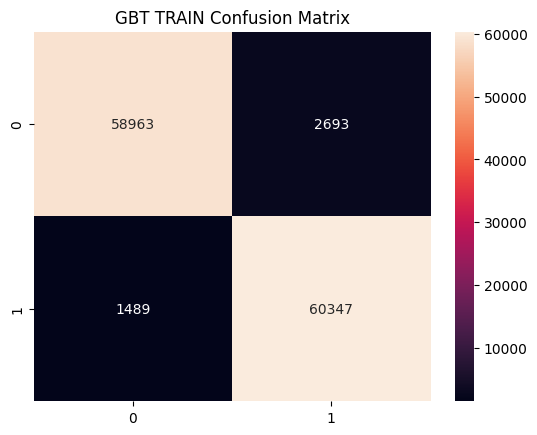

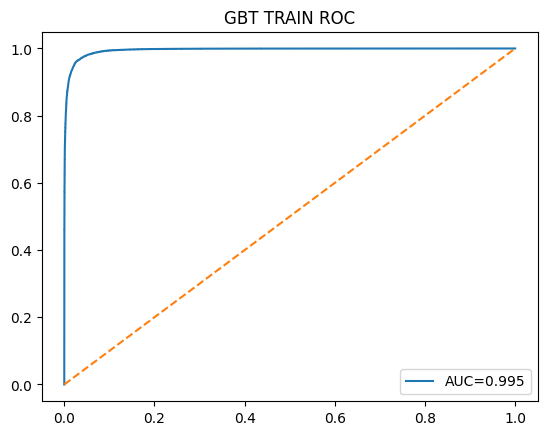

GBT TEST classification report
              precision    recall  f1-score   support

         0.0       0.95      0.84      0.89     26425
         1.0       0.86      0.96      0.91     26501

    accuracy                           0.90     52926
   macro avg       0.91      0.90      0.90     52926
weighted avg       0.91      0.90      0.90     52926



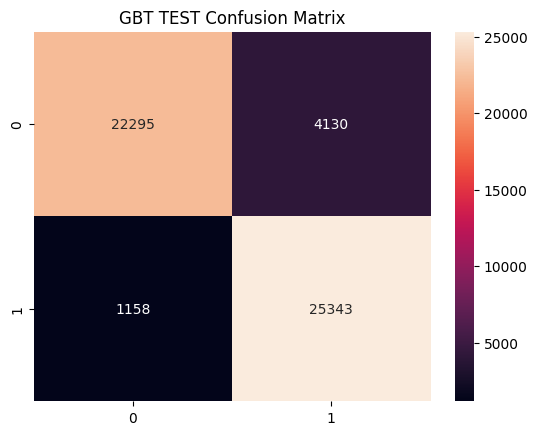

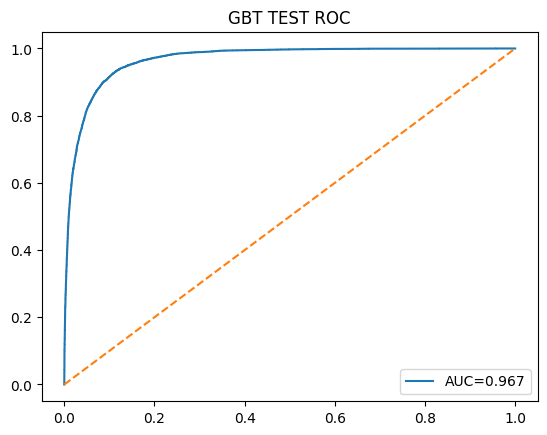

RF TRAIN classification report
              precision    recall  f1-score   support

         0.0       0.69      0.70      0.69     61656
         1.0       0.69      0.68      0.69     61836

    accuracy                           0.69    123492
   macro avg       0.69      0.69      0.69    123492
weighted avg       0.69      0.69      0.69    123492



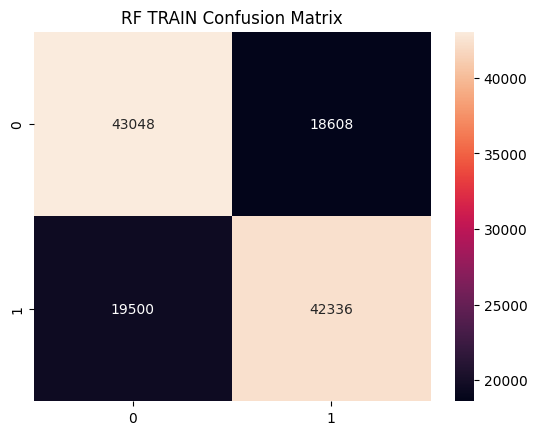

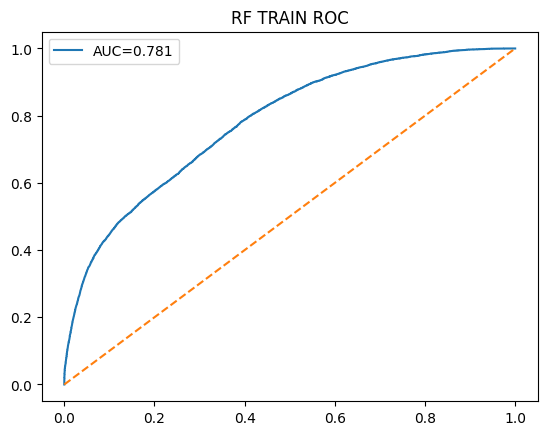

RF TEST classification report
              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67     26425
         1.0       0.67      0.67      0.67     26501

    accuracy                           0.67     52926
   macro avg       0.67      0.67      0.67     52926
weighted avg       0.67      0.67      0.67     52926



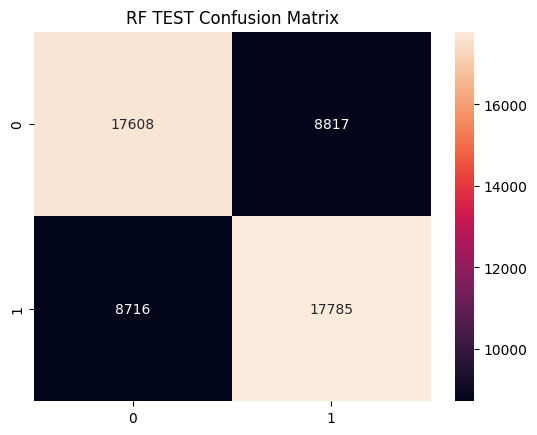

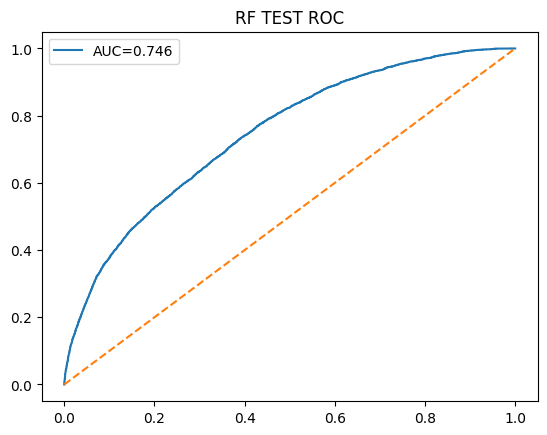

LR TRAIN classification report
              precision    recall  f1-score   support

         0.0       0.58      0.65      0.61     61656
         1.0       0.60      0.54      0.57     61836

    accuracy                           0.59    123492
   macro avg       0.59      0.59      0.59    123492
weighted avg       0.59      0.59      0.59    123492



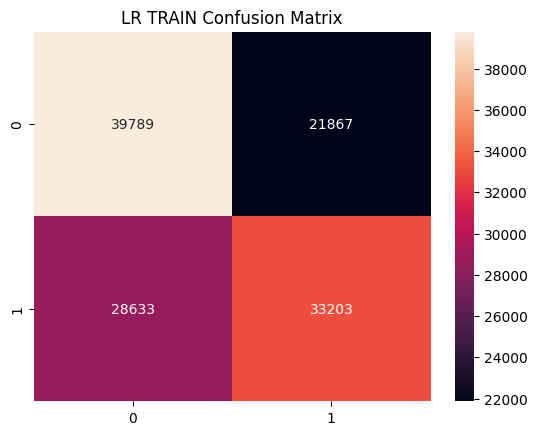

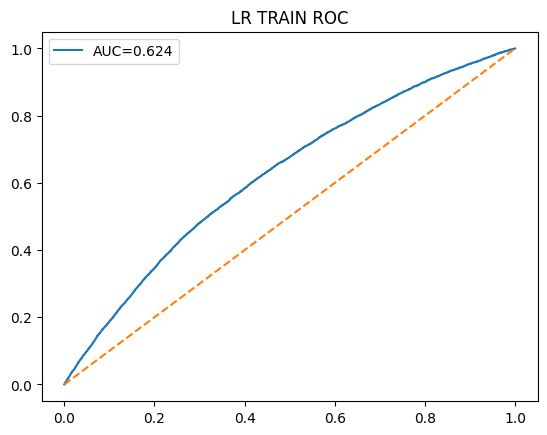

LR TEST classification report
              precision    recall  f1-score   support

         0.0       0.58      0.64      0.61     26425
         1.0       0.60      0.54      0.57     26501

    accuracy                           0.59     52926
   macro avg       0.59      0.59      0.59     52926
weighted avg       0.59      0.59      0.59     52926



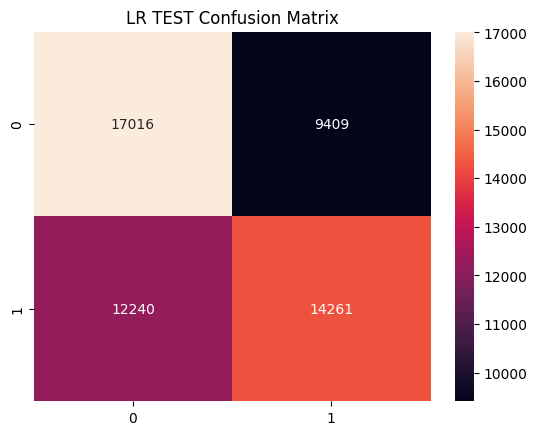

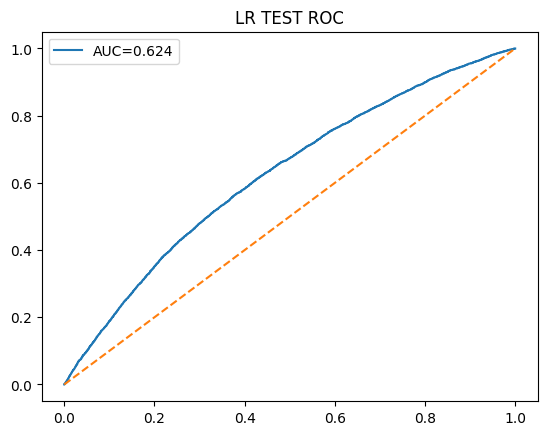

MLP TRAIN classification report
              precision    recall  f1-score   support

         0.0       0.61      0.63      0.62     61656
         1.0       0.61      0.59      0.60     61836

    accuracy                           0.61    123492
   macro avg       0.61      0.61      0.61    123492
weighted avg       0.61      0.61      0.61    123492



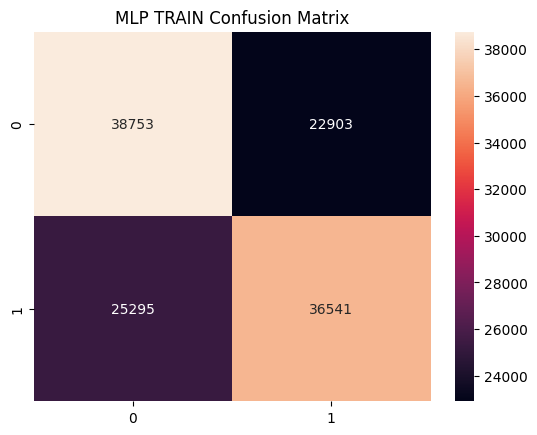

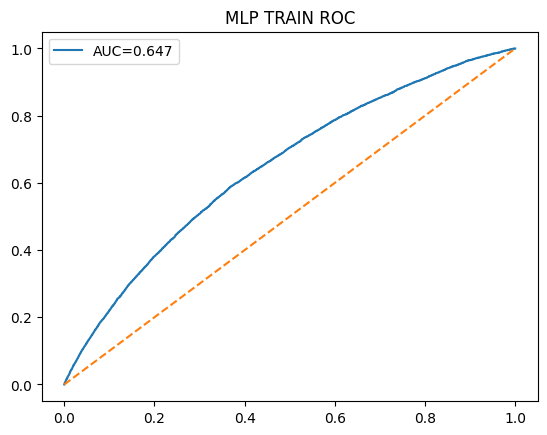

MLP TEST classification report
              precision    recall  f1-score   support

         0.0       0.60      0.62      0.61     26425
         1.0       0.61      0.58      0.60     26501

    accuracy                           0.60     52926
   macro avg       0.60      0.60      0.60     52926
weighted avg       0.60      0.60      0.60     52926



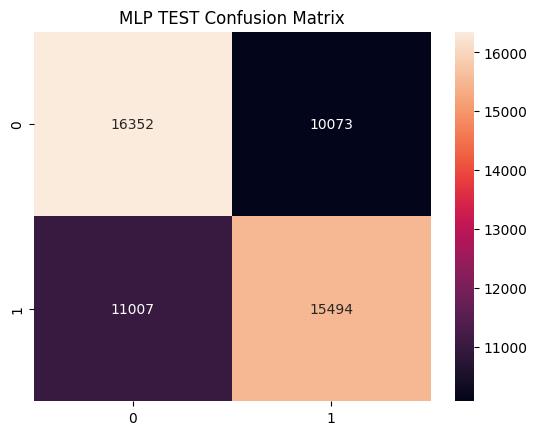

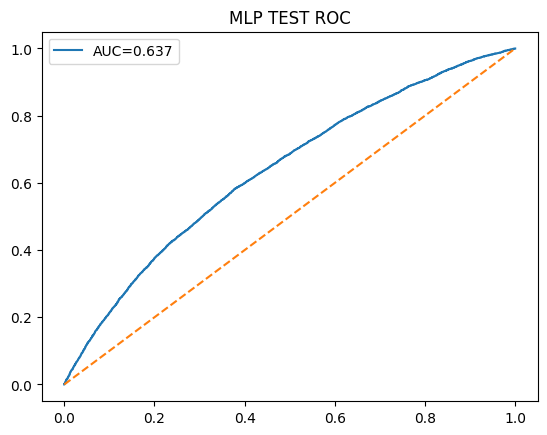

In [21]:
## Cell 9: Evaluation helper & plots
def eval_plot(model,sdf,title):
    pdf=model.transform(sdf).select('prediction','probability',label_col).toPandas()
    from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc
    y_true=pdf[label_col]; y_pred=pdf.prediction
    print(title,'classification report')
    print(classification_report(y_true,y_pred))
    cm=confusion_matrix(y_true,y_pred)
    sns.heatmap(cm,annot=True,fmt='d');plt.title(f'{title} Confusion Matrix');plt.show()
    probs=pdf.probability.apply(lambda v: v[1])
    fpr,tpr,_=roc_curve(y_true,probs); roc_auc=auc(fpr,tpr)
    plt.plot(fpr,tpr,label=f'AUC={roc_auc:.3f}');plt.plot([0,1],[0,1],'--');plt.title(f'{title} ROC');plt.legend();plt.show()

models = {'GBT':gbt_model,'RF':rf_model,'LR':lr_model,'MLP':mlp_model}
for name,mdl in models.items():
    eval_plot(mdl,sdf_train,f'{name} TRAIN')
    eval_plot(mdl,sdf_test, f'{name} TEST')

STACKED classification report
              precision    recall  f1-score   support

         0.0       0.93      0.90      0.92     26425
         1.0       0.91      0.93      0.92     26501

    accuracy                           0.92     52926
   macro avg       0.92      0.92      0.92     52926
weighted avg       0.92      0.92      0.92     52926



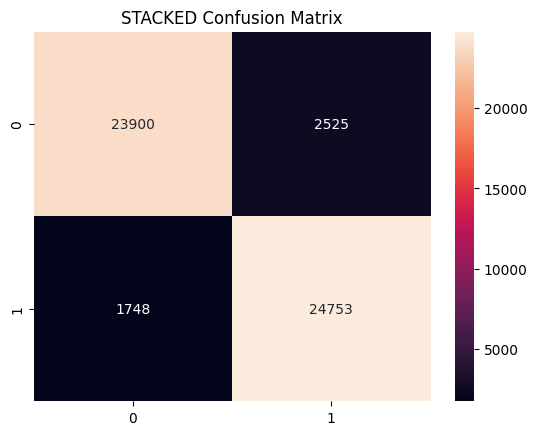

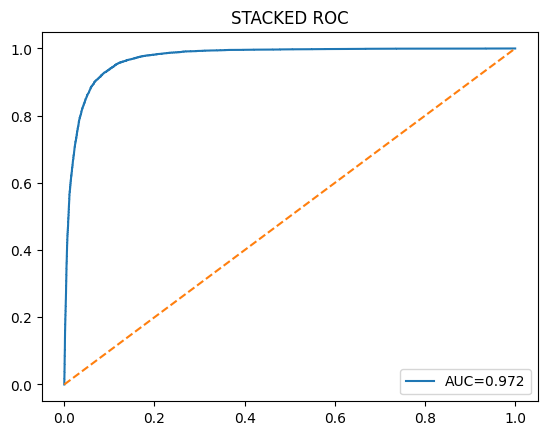

In [23]:
## Cell 10: Stacking ensemble & calibration
from pyspark.sql.functions import udf, col as Ccol
from pyspark.sql.types import DoubleType

# Initialize stacking frame with test features and label
stack = sdf_test.select('features', label_col)

# For each base model, generate probability column and append
for n, mdl in models.items():
    to_prob = udf(lambda v: float(v[1]), DoubleType())
    temp = mdl.transform(stack)
    stack = temp.withColumn(f'{n}_prob', to_prob(Ccol('probability'))).drop('probability', 'rawPrediction', 'prediction')

# Assemble meta-features and train meta-learner
metafeats = [f'{n}_prob' for n in models]
stack = VectorAssembler(inputCols=metafeats, outputCol='meta_feats').transform(stack)
meta_model = LogisticRegression(labelCol=label_col, featuresCol='meta_feats').fit(stack)
eval_plot(meta_model, stack, 'STACKED')

<Figure size 640x480 with 0 Axes>

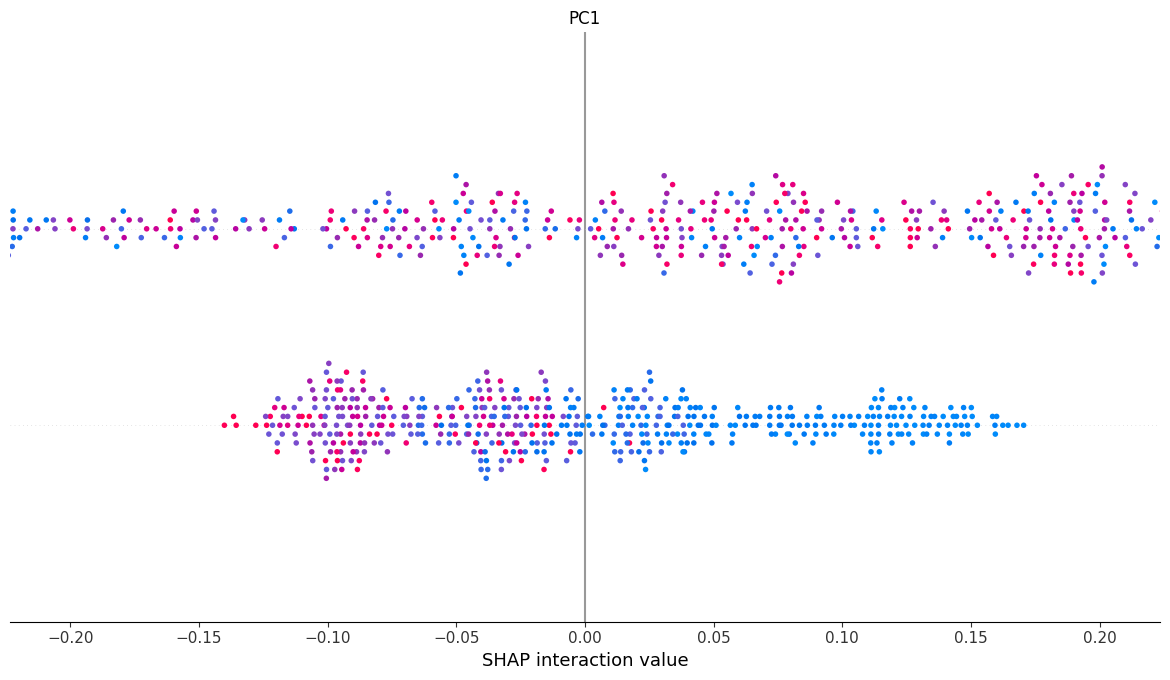

In [24]:
## Cell 11: SHAP explainability
pdf_sample = sdf_train.select(feat_cols + [label_col]).toPandas().sample(500, random_state=42)
X = pdf_sample[feat_cols]; y = pdf_sample[label_col]
from sklearn.ensemble import RandomForestClassifier as SkRF
rf_local = SkRF(n_estimators=100).fit(X, y)
expl = shap.TreeExplainer(rf_local);
sv = expl.shap_values(X)
shap.summary_plot(sv, X, plot_type='bar')

In [25]:
## Cell 12: Save models
os.makedirs('/content/models', exist_ok=True)
for n,mdl in models.items():
    mdl.write().overwrite().save(f'/content/models/{n}_spark')
meta_model.write().overwrite().save('/content/models/stacked_spark')
print('All Phase 2 models saved')

All Phase 2 models saved


In [26]:
# 1) Zip the folder (replace 'my_folder' with your folder name)
import shutil
shutil.make_archive('my_folder', 'zip', '/content/models')

# 2) Download the resulting ZIP file
from google.colab import files
files.download('my_folder.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>